In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define paths
drive_path = '/content/drive/MyDrive'
dataset_folder = '0001ML'
dataset_name = 'archive.zip'
destination_folder = '0001.pro'  # Change this to the desired destination folder

# Full path to the dataset zip file
dataset_zip_path = f'{drive_path}/{dataset_folder}/{dataset_name}'

# Full path to the destination folder
destination_path = f'/content/{destination_folder}'

# Create the destination folder if it doesn't exist
!mkdir -p "{destination_path}"

# Unzip the dataset
!unzip -q "{dataset_zip_path}" -d "{destination_path}"


replace /content/0001.pro/image data/test/Cassava/Bacterial Blight (CBB)/2435784137.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import shutil
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Set the paths
original_dataset_path = '/content/0001.pro/image data'  # Change this path to the root of your dataset
preprocessed_dataset_path = '/content/preprocessed_data1'  # Change this path to the desired location for the preprocessed dataset

# Create directories for the preprocessed dataset
os.makedirs(preprocessed_dataset_path, exist_ok=True)

# Total class: 6 (Considering at least three plants and two diseases of each)
class_mapping = {
    'Cassava_BrownStreakDisease': ['Cassava', 'Brown Streak Disease (CBSD)'],
    'Cassava_MosaicDisease': ['Cassava', 'Mosaic Disease (CMD)'],
    'Corn_CercosporaLeafSpot': ['corn (maize)', 'cercospora leaf spot gray leaf spot'],
    'Corn_NorthernLeafBlight': ['corn (maize)', 'northern leaf blight'],
    'Rice_LeafBlast': ['Rice', 'LeafBlast'],
    'Rice_BrownSpot': ['Rice', 'BrownSpot'],
}

# Iterate through the original dataset and copy images to the preprocessed dataset
for class_name, (plant, disease) in class_mapping.items():
    class_path = os.path.join(preprocessed_dataset_path, class_name)
    os.makedirs(class_path, exist_ok=True)

    plant_disease_path = os.path.join(original_dataset_path, 'train', plant, disease)
    images = list(Path(plant_disease_path).rglob('*.jpg'))

    # Check if there are images in the plant_disease_path
    if not images:
        print(f"No images found for {class_name}. Skipping.")
        continue

    # Split the images into train and validation sets
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Copy images to the corresponding class directories
    for image_path in tqdm(train_images, desc=f'Copying {class_name} train images'):
        shutil.copy(image_path, os.path.join(class_path, image_path.name))

    # Create a separate directory for validation images
    val_class_path = os.path.join(preprocessed_dataset_path, 'validation', class_name)
    os.makedirs(val_class_path, exist_ok=True)

    for image_path in tqdm(val_images, desc=f'Copying {class_name} validation images'):
        shutil.copy(image_path, os.path.join(val_class_path, image_path.name))

print("Preprocessing completed successfully.")


Copying Cassava_BrownStreakDisease train images: 100%|██████████| 297/297 [00:00<00:00, 1032.41it/s]
Copying Cassava_BrownStreakDisease validation images: 100%|██████████| 75/75 [00:00<00:00, 2703.56it/s]
Copying Corn_CercosporaLeafSpot train images: 100%|██████████| 40/40 [00:00<00:00, 591.85it/s]
Copying Corn_CercosporaLeafSpot validation images: 100%|██████████| 11/11 [00:00<00:00, 561.63it/s]
Copying Corn_NorthernLeafBlight train images: 100%|██████████| 69/69 [00:00<00:00, 533.50it/s]
Copying Corn_NorthernLeafBlight validation images: 100%|██████████| 18/18 [00:00<00:00, 557.21it/s]
Copying Rice_BrownSpot validation images: 100%|██████████| 76/76 [00:00<00:00, 3597.50it/s]

Preprocessing completed successfully.


In [ ]:
import os
from sklearn.model_selection import train_test_split
from shutil import copyfile

# Set the paths
original_dataset_path = '/content/preprocessed_data1'  # Update with your actual path
output_path = '/content/split_dataset'

# Define the ratios for train, validation, and test sets
train_ratio = 0.6  # Adjust the ratios based on your dataset size
validation_ratio = 0.2
test_ratio = 0.2

# Create directories for train, validation, and test sets
train_path = os.path.join(output_path, 'train')
validation_path = os.path.join(output_path, 'validation')
test_path = os.path.join(output_path, 'test')

os.makedirs(train_path, exist_ok=True)
os.makedirs(validation_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Iterate through each class in the preprocessed dataset
for class_name in os.listdir(original_dataset_path):
    # Skip the 'validation' directory
    if class_name == 'validation':
        continue

    class_path = os.path.join(original_dataset_path, class_name)
    if os.path.isdir(class_path):
        images = os.listdir(class_path)

        # Debug print to check the current class name and the number of images
        print(f"Class: {class_name}, Number of images: {len(images)}")

        # Check if there are enough samples for each set
        if len(images) < 2:
            print(f"Insufficient samples for class {class_name}. Skipping.")
            continue




        # Split images into train, validation, and test sets
        train_images, test_and_val_images = train_test_split(images, test_size=(validation_ratio + test_ratio), random_state=42)

        if len(train_images) == 0:
            print(f"Insufficient samples for class {class_name}. Skipping.")
            continue

        val_images, test_images = train_test_split(test_and_val_images, test_size=test_ratio / (validation_ratio + test_ratio), random_state=42)

        # Copy images to respective directories
        for image_name in train_images:
            source_path = os.path.join(class_path, image_name)
            destination_path = os.path.join(train_path, class_name, image_name)
            os.makedirs(os.path.dirname(destination_path), exist_ok=True)
            copyfile(source_path, destination_path)

        for image_name in val_images:
            source_path = os.path.join(class_path, image_name)
            destination_path = os.path.join(validation_path, class_name, image_name)
            os.makedirs(os.path.dirname(destination_path), exist_ok=True)
            copyfile(source_path, destination_path)

        for image_name in test_images:
            source_path = os.path.join(class_path, image_name)
            destination_path = os.path.join(test_path, class_name, image_name)
            os.makedirs(os.path.dirname(destination_path), exist_ok=True)
            copyfile(source_path, destination_path)

print("Dataset split into training, validation, and testing sets successfully.")


Class: Rice_BrownSpot, Number of images: 301
Class: Cassava_MosaicDisease, Number of images: 192
Class: Rice_LeafBlast, Number of images: 449
Class: Corn_NorthernLeafBlight, Number of images: 69
Class: Corn_CercosporaLeafSpot, Number of images: 40
Class: Cassava_BrownStreakDisease, Number of images: 297
Dataset split into training, validation, and testing sets successfully.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define input shape based on your images (e.g., 224x224 pixels for VGG architectures)
input_shape = (224, 224, 3)

# Build the CNN model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Fully connected layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization
model.add(layers.Dense(6, activation='softmax'))  # Output layer with 6 classes

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 128)      

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of the pre-trained base model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 21139014 (80.64 MB)
Trainable params: 6424326 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define input shape based on your images (e.g., 224x224 pixels for DenseNet architectures)
input_shape = (224, 224, 3)

# Load the pre-trained DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of the pre-trained base model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (  (None, 1664)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_8 (Dense)             (None, 256)               426240    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 13070662 (49.86 MB)
Trainable params: 427782 (1.63 MB)
Non-trainable params: 12642880 (48.23 MB)
_________

In [ ]:
# Count the number of classes
num_classes = len(class_mapping)

print(f"Number of classes taken: {num_classes}")


Number of classes taken: 6


# **TRain**

# **CNN**

In [ ]:
# Define and train CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Assuming you have a CNN architecture similar to the one in your previous code
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(6, activation='softmax'))

# Compile the model (replace with your desired optimizer, loss, and metrics)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on your training data (replace with your actual training data)
cnn_model.fit(train_generator, epochs=10, validation_data=validation_generator)


Epoch 1/10
26/26 [==============================] - 128s 5s/step - loss: 2.7386 - accuracy: 0.4213 - val_loss: 0.9025 - val_accuracy: 0.5576
Epoch 2/10
26/26 [==============================] - 126s 5s/step - loss: 0.7840 - accuracy: 0.5799 - val_loss: 0.9654 - val_accuracy: 0.5576
Epoch 3/10
26/26 [==============================] - 132s 5s/step - loss: 0.7924 - accuracy: 0.6307 - val_loss: 0.7179 - val_accuracy: 0.7026
Epoch 4/10
26/26 [==============================] - 128s 5s/step - loss: 0.6725 - accuracy: 0.6691 - val_loss: 0.8946 - val_accuracy: 0.6580
Epoch 5/10
26/26 [==============================] - 125s 5s/step - loss: 0.6121 - accuracy: 0.7348 - val_loss: 0.6364 - val_accuracy: 0.7323
Epoch 6/10
26/26 [==============================] - 130s 5s/step - loss: 0.5796 - accuracy: 0.7435 - val_loss: 0.7664 - val_accuracy: 0.7026
Epoch 7/10
26/26 [==============================] - 136s 5s/step - loss: 0.5626 - accuracy: 0.7373 - val_loss: 0.7176 - val_accuracy: 0.6952
Epoch 8/10
26

In [ ]:
# Define and train CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Assuming you have a CNN architecture similar to the one in your previous code
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(6, activation='softmax'))

# Compile the model (replace with your desired optimizer, loss, and metrics)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on your training data (replace with your actual training data)
cnn_model.fit(train_generator, epochs=5, validation_data=validation_generator)


Epoch 1/5
26/26 [==============================] - 130s 5s/step - loss: 2.0600 - accuracy: 0.4560 - val_loss: 0.8662 - val_accuracy: 0.5502
Epoch 2/5
26/26 [==============================] - 124s 5s/step - loss: 0.8071 - accuracy: 0.5502 - val_loss: 0.8248 - val_accuracy: 0.5204
Epoch 3/5
26/26 [==============================] - 124s 5s/step - loss: 0.7456 - accuracy: 0.6493 - val_loss: 0.7959 - val_accuracy: 0.6320
Epoch 4/5
26/26 [==============================] - 126s 5s/step - loss: 0.7067 - accuracy: 0.6691 - val_loss: 0.7404 - val_accuracy: 0.6729
Epoch 5/5
26/26 [==============================] - 129s 5s/step - loss: 0.6456 - accuracy: 0.6952 - val_loss: 0.7285 - val_accuracy: 0.6914


In [ ]:
# Evaluate the model on the validation set
accuracy = cnn_model.evaluate(validation_generator)

# Extract the accuracy value
validation_accuracy = accuracy[1]

# Print the validation accuracy percentage
print(f'Validation Accuracy: {validation_accuracy * 100:.2f}%')


9/9 [==============================] - 11s 1s/step - loss: 0.7306 - accuracy: 0.6914
Validation Accuracy: 69.14%


# **VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers

# Load the pre-trained VGG16 model
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Example of data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# You should adjust the path to your training dataset
train_generator = train_datagen.flow_from_directory(
    '/content/split_dataset/train',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical')

# Example of validation data (you should adjust the path)
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    '/content/split_dataset/validation',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical')
# Freeze the convolutional layers
for layer in base_model_vgg16.layers:
    layer.trainable = False

# Build a new model on top of the pre-trained base model
model_vgg16 = models.Sequential()
model_vgg16.add(base_model_vgg16)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(256, activation='relu'))
model_vgg16.add(layers.Dropout(0.5))
model_vgg16.add(layers.Dense(6, activation='softmax'))

# Compile the model
model_vgg16.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Display the model summary
model_vgg16.summary()

# Train the model on your training data
history_vgg16 = model_vgg16.fit(train_generator, epochs=10, validation_data=validation_generator)


Found 807 images belonging to 6 classes.
Found 269 images belonging to 6 classes.
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 21139014 (80.64 MB)
Trainable params: 6424326 (24.51 MB)
Non-trainable params: 14714688 (5

# **Dense169**

In [ ]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras import models, layers

# Load the pre-trained DenseNet169 model
base_model_densenet169 = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model_densenet169.layers:
    layer.trainable = False

# Build a new model on top of the pre-trained base model
model_densenet169 = models.Sequential()
model_densenet169.add(base_model_densenet169)
model_densenet169.add(layers.GlobalAveragePooling2D())
model_densenet169.add(layers.Dense(256, activation='relu'))
model_densenet169.add(layers.Dropout(0.5))
model_densenet169.add(layers.Dense(6, activation='softmax'))

# Compile the model
model_densenet169.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Display the model summary
model_densenet169.summary()

# Train the model on your training data
history_densenet169 = model_densenet169.fit(train_generator, epochs=5, validation_data=validation_generator)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d_1  (None, 1664)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 256)               426240    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 6)                 1542      
                                                                 
Total params: 13070662 (49.86 MB)
Trainable params: 427782 (1.63 MB)
Non-trainable params: 12642880 (48.23 MB)
_________

# **Accuracy Cheak**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have a validation generator
validation_data = validation_generator

# Predict on the validation set
predictions_cnn = cnn_model.predict(validation_data)

# Get true labels
true_labels = validation_data.classes

# Convert predictions to class labels
predicted_labels_cnn = tf.argmax(predictions_cnn, axis=1)

# Create confusion matrix
conf_matrix_cnn = confusion_matrix(true_labels, predicted_labels_cnn)

# Print confusion matrix
print("Confusion Matrix - CNN Model:")
print(conf_matrix_cnn)

# Classification Report
print("Classification Report - CNN Model:")
print(classification_report(true_labels, predicted_labels_cnn))


9/9 [==============================] - 17s 2s/step
Confusion Matrix - CNN Model:
[[15  5  1  4 14 20]
 [ 9  4  0  3  5 17]
 [ 3  0  0  0  1  4]
 [ 6  0  0  0  3  5]
 [19  8  1  1 11 20]
 [25  6  1  7 13 38]]
Classification Report - CNN Model:
              precision    recall  f1-score   support

           0       0.19      0.25      0.22        59
           1       0.17      0.11      0.13        38
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        14
           4       0.23      0.18      0.21        60
           5       0.37      0.42      0.39        90

    accuracy                           0.25       269
   macro avg       0.16      0.16      0.16       269
weighted avg       0.24      0.25      0.24       269



In [ ]:
# Assuming you have a validation generator
validation_data_vgg16 = validation_generator

# Predict on the validation set
predictions_vgg16 = model_vgg16.predict(validation_data_vgg16)

# Get true labels
true_labels_vgg16 = validation_data_vgg16.classes

# Convert predictions to class labels
predicted_labels_vgg16 = tf.argmax(predictions_vgg16, axis=1)

# Create confusion matrix
conf_matrix_vgg16 = confusion_matrix(true_labels_vgg16, predicted_labels_vgg16)

# Print confusion matrix
print("Confusion Matrix - VGG16 Model:")
print(conf_matrix_vgg16)

# Classification Report
print("Classification Report - VGG16 Model:")
print(classification_report(true_labels_vgg16, predicted_labels_vgg16))


9/9 [==============================] - 185s 20s/step
Confusion Matrix - VGG16 Model:
[[ 4 10  1  3 14 27]
 [10  8  0  2  2 16]
 [ 2  2  0  1  1  2]
 [ 3  3  0  0  2  6]
 [10  9  1  4  9 27]
 [21 15  3  7 11 33]]
Classification Report - VGG16 Model:
              precision    recall  f1-score   support

           0       0.08      0.07      0.07        59
           1       0.17      0.21      0.19        38
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        14
           4       0.23      0.15      0.18        60
           5       0.30      0.37      0.33        90

    accuracy                           0.20       269
   macro avg       0.13      0.13      0.13       269
weighted avg       0.19      0.20      0.19       269



In [ ]:
# Assuming you have a validation generator
validation_data_densenet169 = validation_generator

# Predict on the validation set
predictions_densenet169 = model_densenet169.predict(validation_data_densenet169)

# Get true labels
true_labels_densenet169 = validation_data_densenet169.classes

# Convert predictions to class labels
predicted_labels_densenet169 = tf.argmax(predictions_densenet169, axis=1)

# Create confusion matrix
conf_matrix_densenet169 = confusion_matrix(true_labels_densenet169, predicted_labels_densenet169)

# Print confusion matrix
print("Confusion Matrix - DenseNet169 Model:")
print(conf_matrix_densenet169)

# Classification Report
print("Classification Report - DenseNet169 Model:")
print(classification_report(true_labels_densenet169, predicted_labels_densenet169))


9/9 [==============================] - 60s 6s/step
Confusion Matrix - DenseNet169 Model:
[[17  8  5  2  8 19]
 [12  1  1  1  8 15]
 [ 2  1  2  0  2  1]
 [ 3  1  1  0  4  5]
 [19  2  3  1 11 24]
 [21 10  3  3 22 31]]
Classification Report - DenseNet169 Model:
              precision    recall  f1-score   support

           0       0.23      0.29      0.26        59
           1       0.04      0.03      0.03        38
           2       0.13      0.25      0.17         8
           3       0.00      0.00      0.00        14
           4       0.20      0.18      0.19        60
           5       0.33      0.34      0.34        90

    accuracy                           0.23       269
   macro avg       0.16      0.18      0.16       269
weighted avg       0.21      0.23      0.22       269



9/9 [==============================] - 11s 1s/step


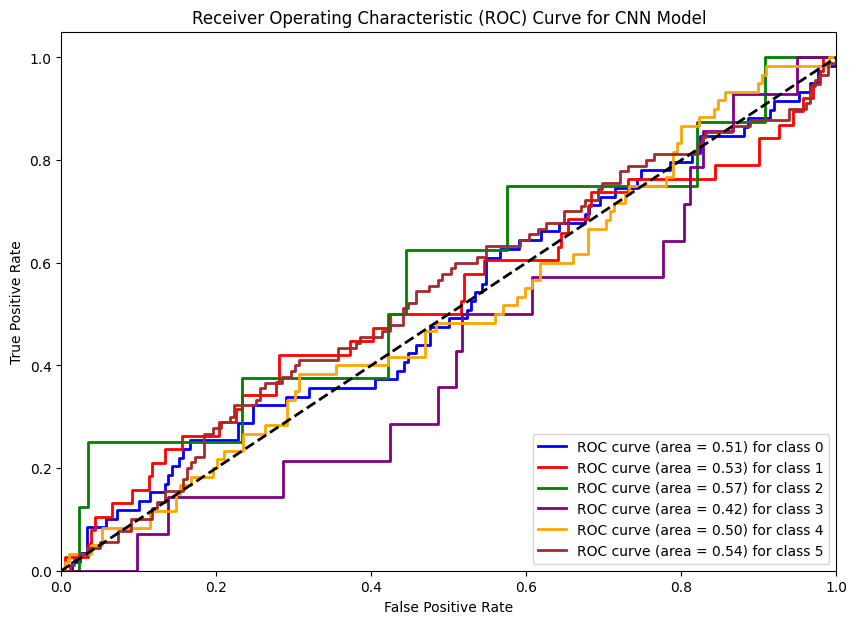

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have a trained CNN model (cnn_model)
y_score_cnn = cnn_model.predict(validation_generator)

# Compute ROC curve and ROC area for each class
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()

for i in range(6):  # assuming 6 classes
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(validation_generator.classes == i, y_score_cnn[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']

for i, color in zip(range(6), colors):
    plt.plot(fpr_cnn[i], tpr_cnn[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc_cnn[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # diagonal line for random model
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for CNN Model')
plt.legend(loc="lower right")
plt.show()


9/9 [==============================] - 166s 18s/step


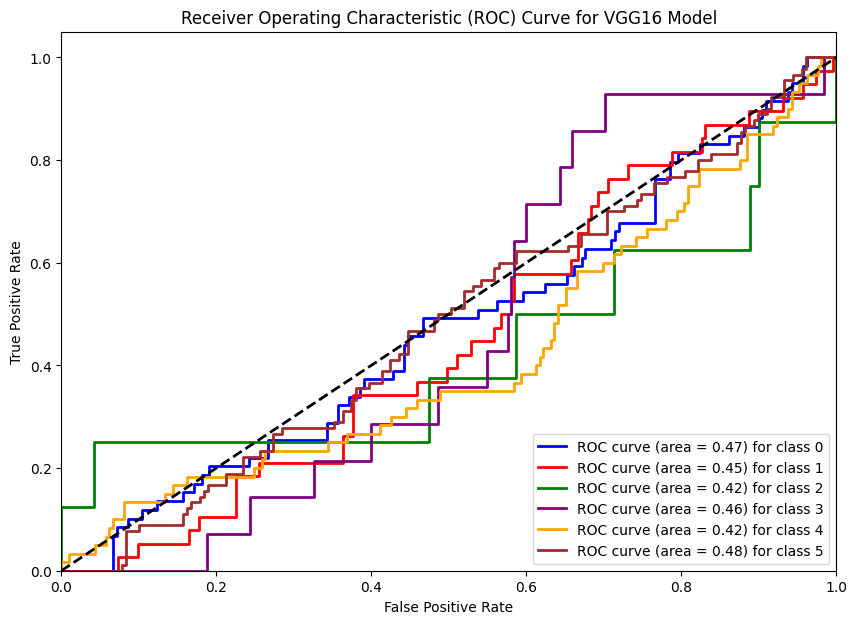

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have a trained VGG16 model (model_vgg16)
y_score_vgg16 = model_vgg16.predict(validation_generator)

# Compute ROC curve and ROC area for each class
fpr_vgg16 = dict()
tpr_vgg16 = dict()
roc_auc_vgg16 = dict()

for i in range(6):  # assuming 6 classes
    fpr_vgg16[i], tpr_vgg16[i], _ = roc_curve(validation_generator.classes == i, y_score_vgg16[:, i])
    roc_auc_vgg16[i] = auc(fpr_vgg16[i], tpr_vgg16[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']

for i, color in zip(range(6), colors):
    plt.plot(fpr_vgg16[i], tpr_vgg16[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc_vgg16[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # diagonal line for random model
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for VGG16 Model')
plt.legend(loc="lower right")
plt.show()


9/9 [==============================] - 55s 6s/step


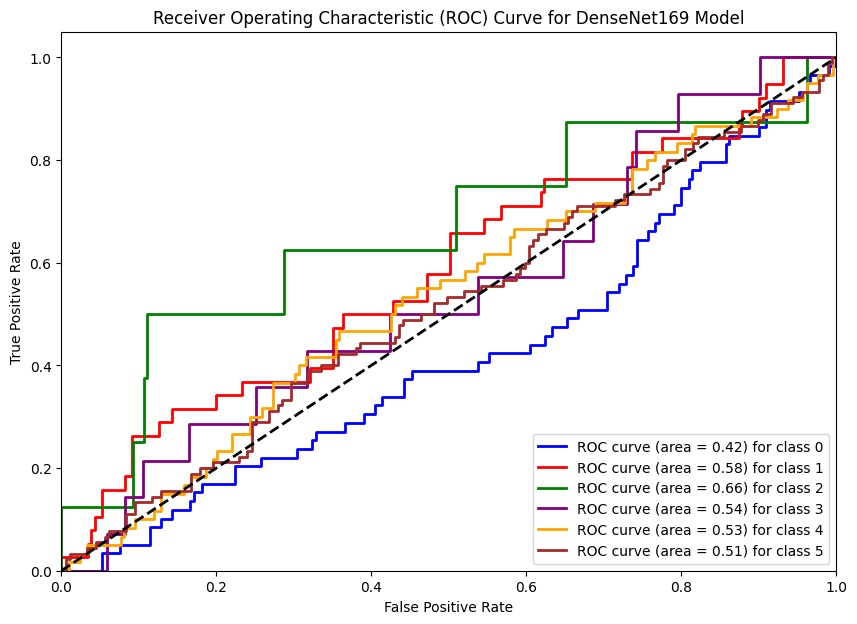

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have a trained DenseNet169 model (model_densenet169)
y_score_densenet169 = model_densenet169.predict(validation_generator)

# Compute ROC curve and ROC area for each class
fpr_densenet169 = dict()
tpr_densenet169 = dict()
roc_auc_densenet169 = dict()

for i in range(6):  # assuming 6 classes
    fpr_densenet169[i], tpr_densenet169[i], _ = roc_curve(validation_generator.classes == i, y_score_densenet169[:, i])
    roc_auc_densenet169[i] = auc(fpr_densenet169[i], tpr_densenet169[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown']

for i, color in zip(range(6), colors):
    plt.plot(fpr_densenet169[i], tpr_densenet169[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc_densenet169[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # diagonal line for random model
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for DenseNet169 Model')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Example test data generator (replace with your actual test data)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/split_dataset/test',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical')

# Assuming you have a test generator
test_data_cnn = test_generator

# Predict on the test set
predictions_test_cnn = cnn_model.predict(test_data_cnn)

# Get true labels
true_labels_test_cnn = test_data_cnn.classes

# Convert predictions to class labels
predicted_labels_test_cnn = tf.argmax(predictions_test_cnn, axis=1)

# Create confusion matrix
conf_matrix_test_cnn = confusion_matrix(true_labels_test_cnn, predicted_labels_test_cnn)

# Print confusion matrix
print("Confusion Matrix - CNN Model (Test Set):")
print(conf_matrix_test_cnn)

# Classification Report
print("Classification Report - CNN Model (Test Set):")
print(classification_report(true_labels_test_cnn, predicted_labels_test_cnn))


Found 272 images belonging to 6 classes.
9/9 [==============================] - 11s 1s/step
Confusion Matrix - CNN Model (Test Set):
[[18  3  0  5  9 25]
 [18  6  0  0  7  8]
 [ 1  0  0  1  2  4]
 [ 5  2  0  1  2  4]
 [14  8  0  1 12 26]
 [22  8  0  7 18 35]]
Classification Report - CNN Model (Test Set):
              precision    recall  f1-score   support

           0       0.23      0.30      0.26        60
           1       0.22      0.15      0.18        39
           2       0.00      0.00      0.00         8
           3       0.07      0.07      0.07        14
           4       0.24      0.20      0.22        61
           5       0.34      0.39      0.36        90

    accuracy                           0.26       272
   macro avg       0.18      0.19      0.18       272
weighted avg       0.25      0.26      0.26       272



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Assuming you have a test generator
test_data_vgg16 = test_generator

# Predict on the test set
predictions_test_vgg16 = model_vgg16.predict(test_data_vgg16)

# Get true labels
true_labels_test_vgg16 = test_data_vgg16.classes

# Convert predictions to class labels
predicted_labels_test_vgg16 = tf.argmax(predictions_test_vgg16, axis=1)

# Create confusion matrix
conf_matrix_test_vgg16 = confusion_matrix(true_labels_test_vgg16, predicted_labels_test_vgg16)

# Print confusion matrix
print("Confusion Matrix - VGG16 Model (Test Set):")
print(conf_matrix_test_vgg16)

# Classification Report
print("Classification Report - VGG16 Model (Test Set):")
print(classification_report(true_labels_test_vgg16, predicted_labels_test_vgg16))


9/9 [==============================] - 170s 18s/step
Confusion Matrix - VGG16 Model (Test Set):
[[11  9  0  5 10 25]
 [ 6  9  1  2  3 18]
 [ 3  2  0  1  1  1]
 [ 2  4  0  2  1  5]
 [ 9 17  1  2  9 23]
 [ 8 21  2  4 15 40]]
Classification Report - VGG16 Model (Test Set):
              precision    recall  f1-score   support

           0       0.28      0.18      0.22        60
           1       0.15      0.23      0.18        39
           2       0.00      0.00      0.00         8
           3       0.12      0.14      0.13        14
           4       0.23      0.15      0.18        61
           5       0.36      0.44      0.40        90

    accuracy                           0.26       272
   macro avg       0.19      0.19      0.18       272
weighted avg       0.26      0.26      0.25       272



In [ ]:
# Assuming you have a test generator
test_data_densenet169 = test_generator

# Predict on the test set
predictions_test_densenet169 = model_densenet169.predict(test_data_densenet169)

# Get true labels
true_labels_test_densenet169 = test_data_densenet169.classes

# Convert predictions to class labels
predicted_labels_test_densenet169 = tf.argmax(predictions_test_densenet169, axis=1)

# Create confusion matrix
conf_matrix_test_densenet169 = confusion_matrix(true_labels_test_densenet169, predicted_labels_test_densenet169)

# Print confusion matrix
print("Confusion Matrix - DenseNet169 Model (Test Set):")
print(conf_matrix_test_densenet169)

# Classification Report
print("Classification Report - DenseNet169 Model (Test Set):")
print(classification_report(true_labels_test_densenet169, predicted_labels_test_densenet169))


9/9 [==============================] - 58s 6s/step
Confusion Matrix - DenseNet169 Model (Test Set):
[[16  3  3  4 10 24]
 [10  5  4  3  8  9]
 [ 2  1  0  0  3  2]
 [ 3  2  1  0  0  8]
 [16  6  2  0 14 23]
 [24 11  0  5 19 31]]
Classification Report - DenseNet169 Model (Test Set):
              precision    recall  f1-score   support

           0       0.23      0.27      0.24        60
           1       0.18      0.13      0.15        39
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        14
           4       0.26      0.23      0.24        61
           5       0.32      0.34      0.33        90

    accuracy                           0.24       272
   macro avg       0.16      0.16      0.16       272
weighted avg       0.24      0.24      0.24       272



In [ ]:
# Compare model performances
accuracy_cnn = accuracy_score(true_labels, predicted_labels_cnn)
accuracy_vgg16 = accuracy_score(true_labels_vgg16, predicted_labels_vgg16)
accuracy_densenet169 = accuracy_score(true_labels_densenet169, predicted_labels_densenet169)

# Print accuracy results
print(f"Accuracy - CNN Model: {accuracy_cnn}")
print(f"Accuracy - VGG16 Model: {accuracy_vgg16}")
print(f"Accuracy - DenseNet169 Model: {accuracy_densenet169}")

# Choose the best model based on accuracy
best_model = max([(accuracy_cnn, 'CNN'), (accuracy_vgg16, 'VGG16'), (accuracy_densenet169, 'DenseNet169')])

# Print the best model
print(f"The best model is {best_model[1]} with accuracy {best_model[0]}")


Accuracy - CNN Model: 0.2527881040892193
Accuracy - VGG16 Model: 0.20074349442379183
Accuracy - DenseNet169 Model: 0.23048327137546468
The best model is CNN with accuracy 0.2527881040892193
